In [2]:
from tensorflow.python.keras import backend as K
K._get_available_gpus()

[]

In [115]:
# Importing libraries
import random
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
from easyimages import EasyImageList,EasyImage
import re
# import pytesseract
import cv2
import easyocr
import tqdm
import contractions
from unidecode import unidecode
from collections import Counter
from torchtext.data import get_tokenizer
from torchtext.data.utils import ngrams_iterator
from ftlangdetect import detect
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import json
from scipy import spatial
from sklearn.manifold import TSNE
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import keras
# from keras.applications.xception import Xception
# from keras.applications.xception import preprocess_input
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
import string
from gensim.models import Word2Vec
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical, pad_sequences
from keras.models import Model
from keras.layers import Embedding, LSTM, add, Dense, Input
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu
from bert_score import score
from transformers import BartTokenizer, BartForConditionalGeneration
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import time
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
random.seed(42)

In [4]:
nltk.download('stopwords') # Downloading the stopwords dataset
nltk.download('punkt') #punkt model for sentence splitting and tokenizing

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sameergupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sameergupta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Exploration

### Image Exploration
* Print the count of images
* Print dimension and plot the dimension to identify if any resizing would be required. CNN's require fix input size, so need to explore on the image size.
* Identify if any of the image is corrupted
* Image Color Intensity to identify dark and light images which could come handy later on to tune the model

In [5]:
PROJECT_DIR = os.getcwd()  # get the current working directory
DATA_DIR = os.path.join(PROJECT_DIR, 'data-old') # Concatenate the folder name which contains images
DATA_DIR  # Check the final path value

'/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old'

In [6]:
# Point to the memes folder from the data directory
image_dir = os.path.join(DATA_DIR, "memes")
print(image_dir)
image_files = os.listdir(image_dir)  # get the meme images filenames from the path
print(f'The meme image file names : {random.sample(image_files, 5)}')  # print 5 random filenames

# Need to check the images with - 'i-dont-give-a-fuck-sexwithoutpermission.jpg

/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes
The meme image file names : ['serj-tankian.jpg', 'grumpy-cat-good.jpg', 'scumbag-analytic-philosopher.jpg', 'epic-beard-man.jpg', 'mindenki-nyugodjon-le-a-picsba.jpg']


In [7]:
image_list = EasyImageList.from_folder(image_dir)
image_list.html(sample=500, size=50)

In [8]:
# Collect memes file attributes
image_count = 0  # variable to keep the count of number of images
image_broken = 0
image_filetypes = {}
image_widths = []
image_heights = []
image_dimensions = {}
image_aspect_ratio = []
image_modes = {}
image_blank = {}

for image_file in image_files:  # Iterate on every meme image
    try:
        image = PIL.Image.open(os.path.join(image_dir, image_file))

        # image count
        image_count += 1

        # Get the count of different extensions for the image
        image_filetypes[image.format] = image_filetypes.get(image.format, 0) + 1

        # retrieve the color mode of each of the image
        image_modes[image.mode] = image_modes.get(image.mode, 0) + 1

        # get the image dimensions
        image_widths.append(image.size[0])
        image_heights.append(image.size[1])

        # get the count of images for each unique dimension
        image_dimensions[image.size] = image_dimensions.get(image.size, 0) + 1

        # determine the aspect ratio of the image
        aspect_ratio = image.size[0] / image.size[1]
        image_aspect_ratio.append(aspect_ratio)

        # determine if image is blank (extrema gives the value of the darkest and lightest pixel)
        # Convert the RGB image to a greyscale and get the extreme pixel values
        extrema = image.convert("L").getextrema()
        # if both the extreme values are same, then the image is just in one color, i.e there is nothing in image (later on we will check what is the caption for the image)
        if extrema[0] == extrema[1]:
            # get the image file and the value of the pixel
            image_blank[image_file] = extrema[0]

        # close the image
        image.close()

    # Exception handling
    except Exception as e:
        print("Could not read image file {}".format(image_file), e)
        image_broken += 1


# Print all the variables
print("Total memes: {}".format(image_count))
print("Broken memes: {}".format(image_broken))
print("Meme file types: {}".format(image_filetypes))
print("Meme modes: {}".format(image_modes))
print("Meme dimensions: {}".format(image_dimensions))
print("Blank memes: {}".format(image_blank))

Total memes: 2504
Broken memes: 0
Meme file types: {'JPEG': 2504}
Meme modes: {'RGB': 2504}
Meme dimensions: {(250, 250): 2461, (224, 224): 2, (227, 227): 2, (248, 248): 1, (213, 213): 1, (200, 200): 3, (194, 194): 1, (226, 226): 1, (216, 216): 2, (230, 230): 2, (150, 150): 1, (225, 225): 5, (245, 245): 1, (232, 232): 1, (240, 240): 2, (174, 174): 1, (199, 199): 1, (157, 157): 1, (135, 135): 1, (195, 195): 1, (183, 183): 1, (211, 211): 1, (360, 356): 1, (208, 208): 1, (170, 170): 1, (222, 222): 1, (128, 128): 1, (180, 180): 1, (220, 220): 2, (233, 233): 1, (197, 197): 1, (210, 210): 1}
Blank memes: {'blank-black.jpg': 0, 'blank-template.jpg': 255}


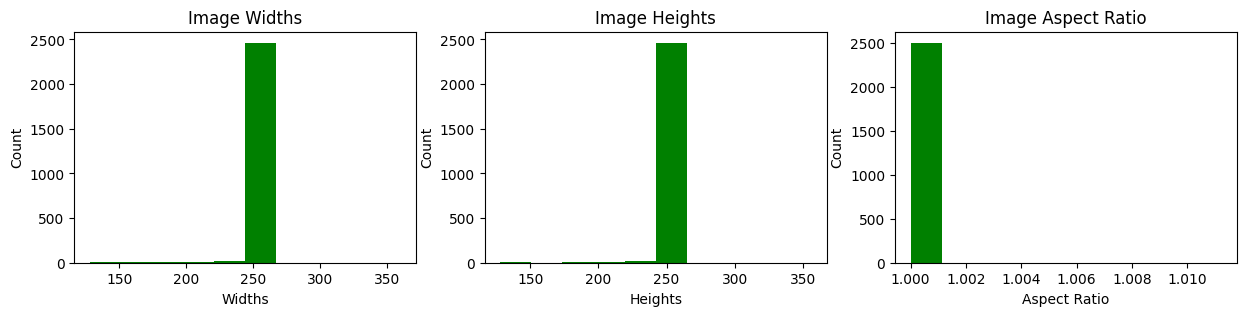

In [9]:
# Get the distribution on the different widths, heights and the aspect ratio of the images
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].hist(image_widths, bins=10,color='green')
ax[0].set_title('Image Widths')
ax[0].set_xlabel('Widths')
ax[0].set_ylabel('Count')

ax[1].hist(image_heights, bins=10,color='green')
ax[1].set_title('Image Heights')
ax[1].set_xlabel('Heights')
ax[1].set_ylabel('Count')

ax[2].hist(image_aspect_ratio, bins=10,color='green')
ax[2].set_title('Image Aspect Ratio')
ax[2].set_xlabel('Aspect Ratio')
ax[2].set_ylabel('Count')

plt.show()

We can see from the plots that the dimensions of most of the images are 250 * 250 and only very few are of dimensions lower than 250. From the meme dimensions variable printed in the previous cell of plot, different dimensions values can be seen and the image count respective to the dimension.
From the aspect ratio it can be seen that we have the square images.
These steps are performed in order to identify the images that would require resizing (images with dimensions other than 250 * 250 ?) - To create the image embeddings we will use **[Inception_V3](https://pytorch.org/hub/pytorch_vision_inception_v3/)** model, and it requires the input size of 299x299x3. So, we will upscale the images. 

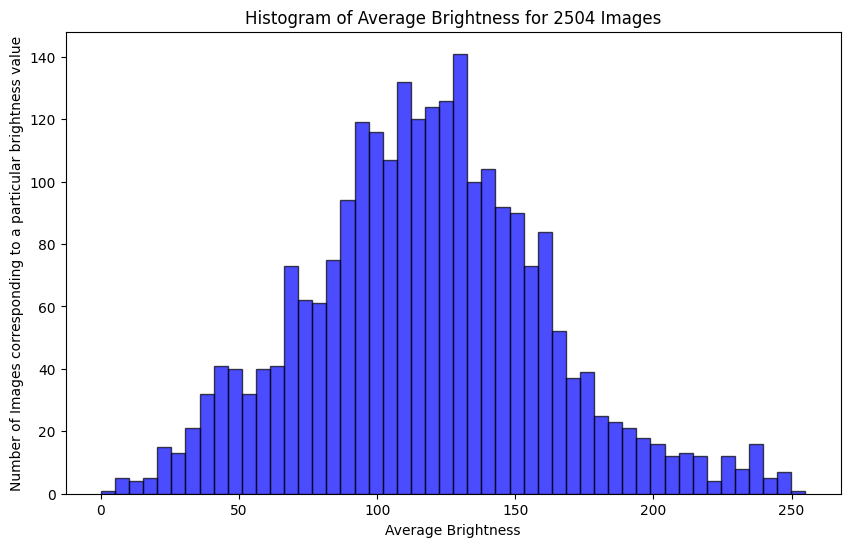

In [10]:
brightness_values = []
darker_image_names = []
lighter_image_names = []

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)

    # Load the image in greyscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Calculate average brightness
    avg_brightness = image.mean()

    # Check if average brightness is less than 50, append the image name to the darker_image_names list
    if avg_brightness < 30:
        darker_image_names.append(image_file)
    elif avg_brightness > 240:
        lighter_image_names.append(image_file)

    # For every image, append the average brightness to the list
    brightness_values.append(avg_brightness)

# Plot histogram of brightness values
plt.figure(figsize=(10, 6))
plt.hist(brightness_values, bins=50, color='blue', alpha=0.7,edgecolor='black')
plt.title(f'Histogram of Average Brightness for {len(brightness_values)} Images')
plt.xlabel('Average Brightness')
plt.ylabel('Number of Images corresponding to a particular brightness value')

# plt.grid(True)
plt.show()

We can see there are some darker images with average brightness on the lower values and some lighter images on the high end values. Brightness can affect feature interpretation of images. May be beneficial to convert the darker image brightness to average image brightness to help in feature detection/interpretation (note to explore)

In [11]:
images_list = []
for dark_img in darker_image_names:
    image_path = os.path.join(image_dir, dark_img)
    images_list.append(EasyImage.from_file(image_path))

EasyImageList(images_list).html()


In [12]:
images_list = []
for light_img in lighter_image_names:
    image_path = os.path.join(image_dir, light_img)
    images_list.append(EasyImage.from_file(image_path))

EasyImageList(images_list).html()

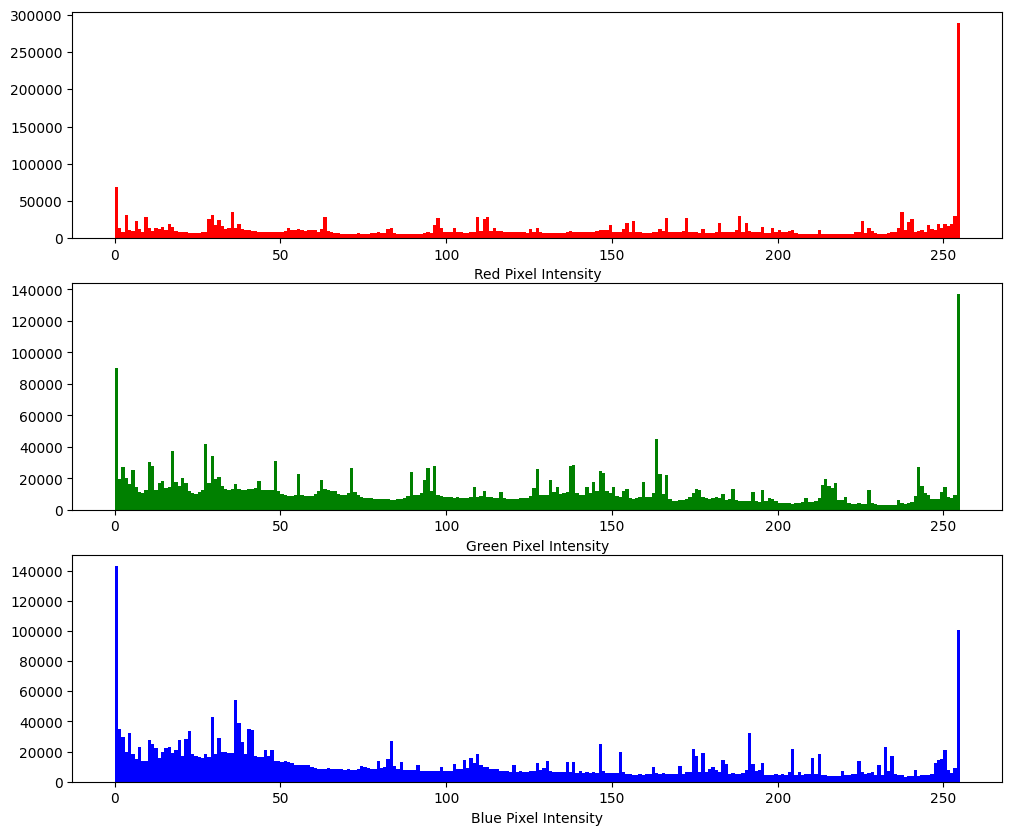

In [13]:
# Image color distribution
colors = {"R": [], "G": [], "B": []}

# For the 50 random images, plot the color distribution
for image_file in random.sample(image_files, 50):
    image = PIL.Image.open(os.path.join(image_dir, image_file))

    image_array = np.array(image)

    colors["R"].extend(image_array[:, :, 0].flatten())
    colors["G"].extend(image_array[:, :, 1].flatten())
    colors["B"].extend(image_array[:, :, 2].flatten())

    image.close()

# Plot color distribution
fig, ax = plt.subplots(3, 1, figsize=(12, 10))
ax[0].hist(colors["R"], bins=255, color = 'red')
ax[0].set_xlabel("Red Pixel Intensity")

ax[1].hist(colors["G"], bins=255, color = 'green')
ax[1].set_xlabel("Green Pixel Intensity")

ax[2].hist(colors["B"], bins=255, color = 'blue')
ax[2].set_xlabel("Blue Pixel Intensity")

plt.show()

### Identification of the Images with text in it

In [14]:
def extract_text_easyocr(image_path,reader_instance):

    # Use the reader to read text from the image
    results = reader_instance.readtext(image_path)

    # Extract and return the text
    extracted_text = "\n".join([result[1] for result in results])
    if len(extracted_text.strip()) > 0:
        return extracted_text

# dictionary to hold the name of the image and the length of text in it
image_with_text = {}

# Create a reader instance
# The line reader = easyocr.Reader(['en']) is for loading a model into memory. It takes some time but it needs to be run only once.(https://github.com/JaidedAI/EasyOCR/tree/master)
print('Model is starting to get load into the memory')
reader = easyocr.Reader(lang_list=['en'], gpu=True, verbose=True)
print('Model loaded into the memory')

for image_file in tqdm.tqdm(image_files):
    image_path = os.path.join(image_dir, image_file) 

    text_retrieved = extract_text_easyocr(image_path,reader)

    if text_retrieved is not None:
        image_with_text[image_file] = text_retrieved  


Model is starting to get load into the memory
Model loaded into the memory


100%|██████████| 2504/2504 [01:09<00:00, 36.19it/s]


In [15]:
# Print sample of images identified with text

random.sample(list(image_with_text.items()), 5)

[('karpin-mem.jpg', 'Tedrdi'),
 ('vargaistvan.jpg', 'Istvan\nPptu Fd1\nVarga !'),
 ('old-success-kid.jpg', 'BxlReay'),
 ('typicalmoldova.jpg', 'MOLDOVAL\nChisiniu ,\nTinasbnl'),
 ('feminist-cunt.jpg', "THIS\nYHAT\n'EMINIS\nOOKs\nLIKE")]

In [16]:
# Get the image name from the dictionary
image_with_text_list = [k for k, v in image_with_text.items()]

images_list = []
for img in image_with_text_list:
    image_path = os.path.join(image_dir, img)
    images_list.append(EasyImage.from_file(image_path,label=[img]))

EasyImageList(images_list).html(by_class=False)

# Note:- The Images have been identified which has text in them. These images are not removed right now, we will train the model
# and if the model output is not good, then we will remove the text from the images or we can remove the imges which just has text in it.

# Captions Text Exploration

In [17]:
# Read the captions file
captions = open(os.path.join(DATA_DIR, "captions.txt"), "r").read()

meme_names = {} # dictionary to store image filename and the meme name
meme_captions = {} # dictionary to store the image filename and the meme captions

previous_captions_img_filename = None

# Collect memes and their associated captions
for line in captions.split("\n"):
    # if the line does not contain a dash, it is a continuation of the previous caption
    if line.find('-') == -1 and previous_captions_img_filename is not None:
        meme_captions[previous_captions_img_filename][-1] += " " + line.strip()
        continue

    # Find the index of the dash which separates the image name and the caption
    split_index = line.index(' - ')
    name, caption = line[0:split_index].strip(), line[split_index + 3:].strip()

    # Ignore the empty meme caption
    if not caption:
        continue

    # generate meme image file name - remove special characters and convert to lowercase.
    # It would be an appropriate way to compare for which images captions are available, as
    # there are lot of discrepancies in the names format in image and captions file.
    captions_img_file_name = re.sub(r"[^a-zA-Z0-9]+", '', name.lower()) + ".jpg"

    # The meme_names is prepared to create the image file name so that it can be compared to which image the captions belong to
    meme_names[captions_img_file_name] = name

    # Add all the captions associated with the particular image
    meme_captions[captions_img_file_name] = meme_captions.get(captions_img_file_name, []) + [caption]

    previous_captions_img_filename = captions_img_file_name  # Add the processed image name


In [18]:
# Remove the hypens from the images filename to make it consistent with the filename created from captions names
image_filenames_without_dash = set(map(lambda x: x.replace('-', ''), image_files))

# Find the images for which there is no associated captions
no_captions = set(image_filenames_without_dash) - set(meme_captions.keys())
print(f'The total number of images for which no captions were found are :{len(no_captions)}')

# Print a random sample of images for which no captions were found
print('Sample of images with no captions')
random.sample(list(no_captions), 5)

# Need to remove the images for which the captions were not found from consideration in training samples

The total number of images for which no captions were found are :32
Sample of images with no captions


['stavropoltypical.jpg',
 'carois1.jpg',
 'quhorror.jpg',
 'duvetattdursvensknr.jpg',
 'taemin.jpg']

In [19]:
# identify the index of the image file in set
list(image_filenames_without_dash).index('whynotluna.jpg')

875

In [20]:
# Find out the captions for which there is no image available
no_image = set(meme_captions.keys()) - set(image_filenames_without_dash)
print(f'No. of captions for which no image file is available : {len(no_image)}')
no_image

# Note : The .jpg is coming because we have converted the name of the captions to .jpg format to match with image name
# That is how the dataset has been prepared.

No. of captions for which no image file is available : 3


{'duckdynasty.jpg', 'releasethekraken.jpg', 'snsd.jpg'}

In [21]:
# Remove the captions for which the image was not found
for filename in no_image:
    meme_captions.pop(filename)
    meme_names.pop(filename)

We decided to remove the captions for which no images were found because by including these captions, we have no context to what a corresponding image looks like. We feel that only captions with which we can analyze the image should be included for a cleaner and more accurate unique caption generation.

In [22]:
# Remove the image and it's associated captions for the completely dark and light image
meme_captions.pop('blankblack.jpg')  #black image
meme_names.pop('blankblack.jpg')

meme_captions.pop('blanktemplate.jpg') #white image
meme_names.pop('blanktemplate.jpg')

'Blank Template'

Text Pre-processing

* Remove multiple spaces
* Convert text to lowercase
* Convert non-english to english
* Convert contractions

In [23]:
# An example block
# caption = "Hello, this is some non-ASCII text: Café and Pokémon."
# caption = '¿Qué te gusta hacer?'
caption = 'No hablo español'
ascii_caption = unidecode(caption)

print(ascii_caption)

No hablo espanol


The function **preprocess_captions** is written to perform below steps - 
1. ***<u>Remove multiple spaces and multiple punctuation marks</u>*** : They will not add any value to the meme generation. Additionally, in the text exploration it was found that some of the captions only have the punctuation marks. Eg - '!!!!!!!!!', '.................'. For the memes we need text, so that our model can have better context.

2. ***<u>Convert Non-ASCII charcters to ASCII characters</u>***: We are generating memes in English language, and in English language there is no unicode characters.<br>
3. ***<u>Removal of URL's</u>***: URL's do not give any funny information about image. So, it will be unnecessary to keep URL's.<br>
4. ***<u>Expanded contractions</u>***: The contractions need to be expanded to remove ambiguity. For example - you're can mean "you are" and "you were". We are going to use the pre-trained embeddings GloVe, and it will be beneficial to expand contractions to ensure that each word aligns well with the pre-trained vectors. Furthermore, when we will train the model and will generate the memes, we can revisit the point.<br>
5. ***<u>Removed hypen and forward slash ocurring between words</u>***: It was done to reduce the vocabulary size.<br>
6. After performing all the above steps, the text was again checked for spaces.

In [24]:
# Example to check if __and / will be removed
re.sub(r'(?<=\w)[-\/_](?=\w)', ' ', 'teenager___posts/tumblr')

'teenager   posts tumblr'

In [25]:
def preprocess_captions(caption):
    """
    Preprocess the captions of the memes
    """

    # Remove multiple spaces and multiple punctuation marks
    caption = re.sub(r"\s+", " ", caption)
    # Replace same punctuation marks occurring multiple times with a single instance
    # caption = re.sub(r"([.?!])\1+", r"\1", caption)

    # Replace same punctuation marks occurring multiple times with a single instance
    caption = re.sub(r"([^A-Za-a0-9])\1+", r"\1", caption)
   
    # Change the non-ascii characters to ascii characters
    caption = unidecode(caption)

    # Remove URLs 
    caption = re.sub(r"http\S+", "", caption)

    # Expand contractions
    caption = contractions.fix(caption)

    # Split the words joined with hypen or forward slash
    # Eg - "a self-initiated-process" will be converted to - "a self initiated process"
    # caption = re.sub(r"([a-zA-Z0-9])[-\/]([a-zA-Z0-9])", r"\1 \2", caption)
    caption = re.sub(r'(?<=\w)[-\/_](?=\w)', ' ', caption)

    # Remove multiple spaces 
    caption = re.sub(r"\s+", " ", caption)

    return caption.lower()

# Check some of the examples
print(preprocess_captions('Sono economicamente messi peggio di noi italiani riescono a permettersi una rete migliore della nostra, tanto da definirsi "Iper-connessionati"'))
print(preprocess_captions('I told him we\'re sending the national un-watering team!'))
print(preprocess_captions('I told-him-we-are - a/team!'))
print(preprocess_captions('remake$$$$$$$$$$$$$$$'))

sono economicamente mesi pegio di noi italiani riescono a permetersi una rete migliore dela nostra, tanto da definirsi "iper conesionati"
i told him we are sending the national un watering team!
i told him we are - a team!
remake$


#### After performing the pre-processing step, it is checked that there are no duplicate captions for each of the image/caption name. If there are any duplicate captions those are removed.
It is also removed so while training the model, repetition and some bias is reduced towards specific terms showing in a specific order. 

In [26]:
# Remove duplicate captions from the array
for filename, captions in meme_captions.items():
    # Pre-process captions
    captions = list(map(preprocess_captions, captions))

    # Remove duplicate captions
    original_length = len(captions)

    # get the count of each caption
    counter = Counter(captions)

    # get the captions which are duplicate
    duplicates = [item for item, count in counter.items() if count > 1]

    # remove the duplicate captions
    meme_captions[filename] = list(set(captions))

    new_length = len(meme_captions[filename])

    # The below code is written so that on GitHub the long output is not generated
    if False and original_length != new_length:
        print("Removed {} duplicate captions from {}".format(
            original_length - new_length, filename
        ))
        # print the duplicate captions
        print("Duplicate captions: {}".format(duplicates))

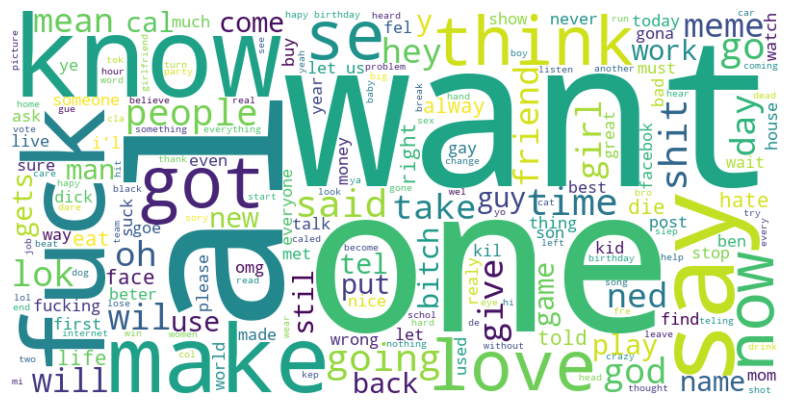

In [27]:
#Using unique captions to capture the most popular words

# Combining all of the captions into one long string
combined_text = " ".join(str(text) if isinstance(text, str) else " ".join(text) for text in meme_captions.values())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(combined_text) # Generating wordCloud

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

From this Word Cloud we can see the most commonly occuring words within our meme captions. From this word cloud we can see tha a good amount of captions contain some angle of profanity, which will need to be replaced. We will likely replace the profanity with a series of specific characters. This Word Cloud contains Stop Words. We wanted to identify what words come more frequently as for our model, stopwords WILL be necessary in caption generation due to the nature of meme captions. 

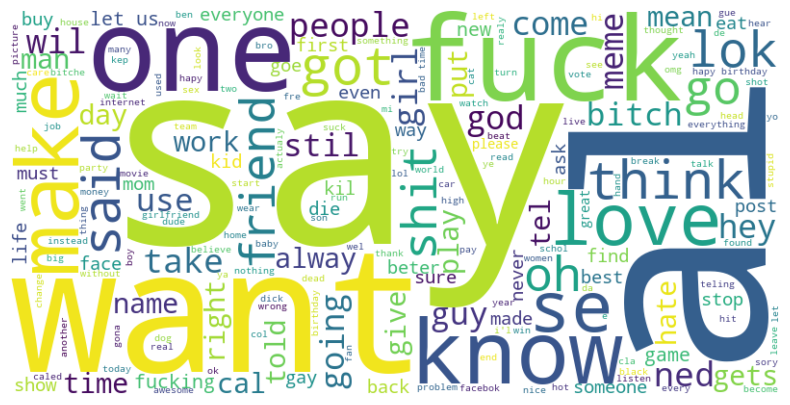

In [28]:

# split it into words
words = combined_text.split()

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from the sentence
filtered_sentence = [word for word in words if word.lower() not in stop_words]

# Join the filtered words back into a sentence
filtered_sentence = ' '.join(filtered_sentence)

wordcloud_noStop = WordCloud(width=800, height=400, background_color="white").generate(filtered_sentence) #Generating wordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_noStop, interpolation="bilinear")
plt.axis("off")
plt.show()

The above Word Cloud does not contain stopwords, giving us a look at higher word frequencies in our captions that are not stopwords. This Word Cloud is more for reference. We have decided to not omit stopwords from our training corpus for caption generation. 

Tokenizing all of the captions. We will use this when creating the text embedding.

In [29]:
# Generate vocabulary from the captions
tokenizer = get_tokenizer("basic_english")
vocab = []
for filename, captions in meme_captions.items():
    for caption in captions:
        # Add all the tokens created by (tokenizer(caption)) to the vocab list (extend adds multiple elements to the list)
        vocab.extend(tokenizer(caption))

print("Vocabulary size: {}".format(len(set(vocab))))

Vocabulary size: 146032


### Identify the occurrence of the least used words in captions. Analyze if those words would be worth keeping so that we can avoid unnecessary vocabulary size.

For count 1 ['nananananananananananananananananananananananananananananana', '#takesyouforevertoread', '01001100011001010111010001110011001000000110011101100101011101000010000001101001011101000010000001101111011011100010000001110100011011110110111001101001011001110110100001110100', 'analytics@socialbrothers', 'wubwubwubwawawaawobwobwob', 'fffffffffffuuuuuuuuuuuuu', 'fffffffffuuuuuuuuuuuu-', 'fuuuuuuuuuuuuuuuuuuuuuuuuuuuuu', 'ffffffffffuuuuuuuuuuuuuuuuuu', 'mmmmwwwaaaahhhaaahhhaaa', 'neishxjqoaopqkencnwiannwkanchwkanxkflwlxjrbwkansndnfkelnznw', 'gahwahfebenlebenargle', 'uuuuuuuuuuuuuuuugggggggggggggggg', 'asijfghiuayewfiaviuaytvjfevk', '23579888988588783701132217644322286884', '#wewantjustinstwiterback', 'fzw3gagv45vb254tgw564he7bh46bw6b546w7whn54nvqf455b3w6nj', 'jajajajajajajajajajaja', 'hahahahahahahahahahahahahahahahahaha', '#kilalstraightwhitemen', 'fapfapfapfapfapfapfap', 'heheheheheheheheheheh', 'intertouchdownception', 'oakxjspsnsjznappmapzkqos', 'aaaaaaaaaaaaaahhhhhhhhhh', 'auhe

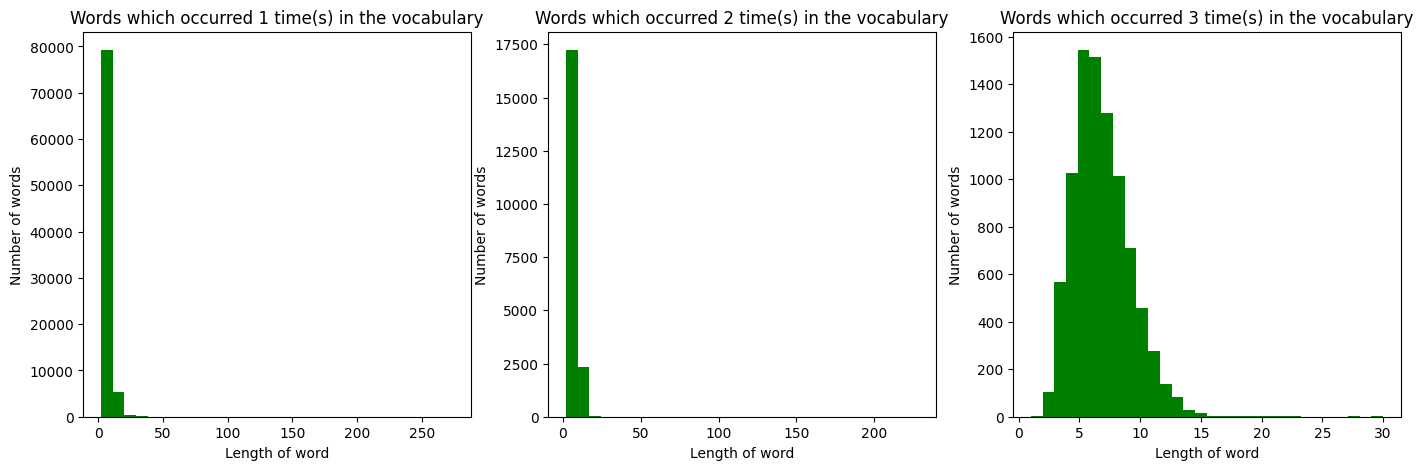

In [30]:
# Count the occurrence of words in vocabulary
wordcount = Counter(vocab)
# Plot the length of words which has the count of 1,2,3

# Create a subplot for each count
fig,ax = plt.subplots(1, 3, figsize=(17, 5))

for i in range(1,4):
    # Get the words which has the count equal to i
    words = [word for word, count in wordcount.items() if count == i]

    # Print the word which is of length > 20
    print(f'For count {i}',[word for word in words if len(word) > 20])   

    # Plot the histogram
    ax[i-1].hist([len(word) for word in words], bins=30,color='green')
    ax[i-1].set_title(f'Words which occurred {i} time(s) in the vocabulary')
    ax[i-1].set_xlabel("Length of word")
    ax[i-1].set_ylabel("Number of words")

# Note:- We can see the presence of words which would not make sense even for meme generation

We have analyzed that the words whose length is greater than 20 are not the good words i.e. they do not have any meaning even for memes. It seems like somebody have made the captions by just inputting random characters. Example - asijfghiuayewfiaviuaytvjfevk, 23579888988588783701132217644322286884. There are also captions which are just the numbers, so we want to remove those too. However, we will keep the text that starts with #tag.

In [31]:
# Get the words where length of the word is greater than 20, but remove the words which start with #
# from consideration of the words with length > 20.
# We have analyzed the words, and there are no words that start with word and have # between them (^'[^#].*#)
least_common_words = [word for word, count in wordcount.items() if len(word) > 20 and word[0] != '#']
least_common_words

['nananananananananananananananananananananananananananananana',
 '01001100011001010111010001110011001000000110011101100101011101000010000001101001011101000010000001101111011011100010000001110100011011110110111001101001011001110110100001110100',
 'mayoupleasrepethaword',
 'analytics@socialbrothers',
 'wubwubwubwawawaawobwobwob',
 'fffffffffffuuuuuuuuuuuuu',
 'fffffffffuuuuuuuuuuuu-',
 'fuuuuuuuuuuuuuuuuuuuuuuuuuuuuu',
 'ffffffffffuuuuuuuuuuuuuuuuuu',
 'mmmmwwwaaaahhhaaahhhaaa',
 'neishxjqoaopqkencnwiannwkanchwkanxkflwlxjrbwkansndnfkelnznw',
 'gahwahfebenlebenargle',
 'uuuuuuuuuuuuuuuugggggggggggggggg',
 'ahahahahahahahahahaha',
 'asijfghiuayewfiaviuaytvjfevk',
 '23579888988588783701132217644322286884',
 'fzw3gagv45vb254tgw564he7bh46bw6b546w7whn54nvqf455b3w6nj',
 'jajajajajajajajajajaja',
 'hahahahahahahahahahahahahahahahahaha',
 'fapfapfapfapfapfapfap',
 'heheheheheheheheheheh',
 'intertouchdownception',
 'oakxjspsnsjznappmapzkqos',
 'aaaaaaaaaaaaaahhhhhhhhhh',
 'auhejcofpqpfkcnrjsotjk

In [32]:
# Replace the least common words with <unk>

for filename, captions in meme_captions.items():
    for i, caption in enumerate(captions):
        captions[i] = " ".join(
            [
                "<unk>" if word in least_common_words else word
                for word in tokenizer(caption)
            ]
        )

In [33]:
# Remove all captions with just <unk>, less than 3 tokens and just punctuations - to get more clean tokens
# which would be helphul in training the model

def is_valid_caption(caption):
    """
    Check if the caption is valid
    """
    
    tokens = tokenizer(caption)

    if len(tokens) < 3:  # Check if only 2 tokens are present
        return False

    if set(tokens) == {"<unk>"}: # Check if all the tokens are <unk>
        return False

    # Check if the tokens are alphanumeric
    alphanumeric_tokens = list(filter(lambda x: x.isalnum(), tokens))

    # If there are no alphanumeric tokens, then return false 
    if set(alphanumeric_tokens) == '':
        return False
    
    return True   
  

for filename, captions in meme_captions.items():
    # Collect the list of captions which were not valid, i.e would be removed
    invalid_captions = list(filter(lambda x: not is_valid_caption(x), captions))

    # Retrieve the valid captions (filter function is applied to each element of the iterable)
    captions = list(filter(is_valid_caption, captions))

    # Code written to avoid long outputs on GitHub
    if False and invalid_captions:
        print("Removed {} captions from {}".format(len(invalid_captions), filename))
        print("Removed captions are: {}".format(invalid_captions))

    meme_captions[filename] = captions

*Function **is_english_text** is written to identify the language of captions. We want all captions to be in English. The langdetect library was taking too much time to identify the language, so we resorted to [fasttext-langdetect library](https://pypi.org/project/fasttext-langdetect/).<br><br>
The fasttext-langdetect library was also not providing accurate results, so we adopted a custom technique, where we tokenize the captions and created <u>n=3 grams</u>. <br><br>
For all the n grams created for the processed caption, language detection was done individually using fasttext-langdetect. After language detection, we placed a condition --> if more than 30% of the n-grams belong to english language, then the processed caption will belong to English language, otherwise the caption will be appended to non_english_captions list.*

In [34]:
def is_english_text(caption):
    """
    Identification of the language of the text
    """

    tokens = tokenizer(caption)

    languages = [detect(text=ngram)["lang"] for ngram in ngrams_iterator(tokens, 3)]

    
    is_english = (
        len([lang for lang in languages if lang == "en"]) / len(languages)
    ) > 0.3

    return is_english

non_english_captions = []

# Idetify the non-english captions
for filename, captions in tqdm.tqdm(meme_captions.items()):
    for i, caption in enumerate(captions):
        if not is_english_text(caption):
            non_english_captions.append(caption)

print(len(non_english_captions))
random.sample(non_english_captions, 10)

100%|██████████| 2454/2454 [00:38<00:00, 63.59it/s] 

30227


['mor flagz pleze',
 'spanishc lernen oder thesis schreiben',
 'fear us , puny humanz',
 'leio muito paso o dia no facebok',
 'ha ha fal',
 'trabalha them lisboa viva na margem sul',
 'poor bastard . apenas es el comienzo',
 'dices que vas al concierto de justin bieber',
 'usted es weon ? o cree que jorge anda en bici por hacer deporte',
 'es ist freitag der fick ist organisiert']

In [35]:
# Checkpoint, save the preprocessed captions file
np.save(os.path.join(PROJECT_DIR, "non_english_captions.npy"), non_english_captions)

#### Update Non-English Captions

We want our captions all to be in English, so that our model can be trained properly in one language and does not provide random results.
We also want to make sure that we are not sending noise to the model, as meme generation itself is funky and humorous.

In [36]:
# Function to update non-english captions in meme_captions variable with identified english translation.
# The english translation is in the file - optimized_translated_captions.json
def update_meme_captions(meme_captions, optimized_translated_captions):   
    
    # Loop through the dictionary to replace the non-english captions with the english captions
    for filename, captions in tqdm.tqdm(meme_captions.items()):  
        # Loop through all the captions for the processed filename      
        for i, caption in enumerate(captions):
            # If the caption is found in the dictionary of optimized_translated_captions
            # then replace the meme_captions variable processed caption with the english caption
            if optimized_translated_captions.get(caption) is not None:
                meme_captions[filename][i] = optimized_translated_captions[caption]                    

In [37]:
TRANSLATED_CAPTIONS_DIR = os.path.join(PROJECT_DIR, "sameer-processed-folder/optimized_translated_captions.json")

# Load the optimized_translated_captions.json file into a Python dictionary
with open(TRANSLATED_CAPTIONS_DIR, 'r') as f:
    optimized_translated_captions = json.load(f)

# Call the function to update non-english captions in meme_captions variable
update_meme_captions(meme_captions, optimized_translated_captions)

100%|██████████| 2454/2454 [00:00<00:00, 48252.20it/s]


In [38]:
# Random spot check if the caption was correctly updated. With the help of printed file name, captions.txt was checked
for file,cap in meme_captions.items():
    for i,c in enumerate(cap):
        if c == 'I was the one who gave the prescription to Inter!':
            print(file)

michelemisseri.jpg


After updating the identified non-english captions with english captions, the fasttext-langdetect library was used again to know
if it still identifies text to be non-english. As we can see, it still marks 6712 captions as non-english captions, and when we analyzed
those captions they were actually not non-english. Additionally, we have used Google Translation for Translation and we know it is more robust and accurate.

We can say that the fasttext-langdetect is giving out the 6712 False Negatives for the English Class. It is due to the reason that the fasttext models are trained on data from Wikipedia, Tatoeba and SETimes which have the formal writing of text for 176 languages. In our scenario we have the memes which have very informal writing like use of short forms to represent words Example - "u" or "y" for "you', "wat" for "what", slangs, characters omitted from the correct spelling of the word etc. 

In [39]:
non_english_captions = []
# Translate captions to english
for filename, captions in tqdm.tqdm(meme_captions.items()):
    for i, caption in enumerate(captions):
        if not is_english_text(caption):
            non_english_captions.append(caption)

print(len(non_english_captions))
random.sample(non_english_captions, 10)

  0%|          | 0/2454 [00:00<?, ?it/s]

100%|██████████| 2454/2454 [00:34<00:00, 71.81it/s] 

6715


['chinky jizz face',
 'f . ing noobs',
 'oh mer gerd i lerv yer terb',
 'i am batman',
 'strict woster aw ye',
 'rip 1929 2012',
 'ermahgerd lenerverrrr !',
 'iza in bout = iza no barco',
 'elisa , ramona , gloria y you no fear me ? !',
 'oh come all ye hateful']

In [40]:
PROJECT_DIR = os.getcwd()  # get the current working directory
processed_dir = os.path.join(PROJECT_DIR, 'sameer-processed-folder') # Concatenate the folder name which contains images
processed_dir

'/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/sameer-processed-folder'

In [41]:
# Finally save the preprocessed captions which are all in english language for future use
with open(os.path.join(processed_dir, "cleaned_english_captions.json"), "w") as f:
    json.dump(meme_captions, f)

In [42]:
# # Load the data
# with open(os.path.join(processed_dir, "cleaned_english_captions.json"), "r") as f:
#     meme_captions = json.load(f)

## Image Preprocessing

In [43]:
# #Resizing the images to be 299 x 299 as that is required by inception v3 model
# #As all images are smaller than this size, we will need to upscale all images

# resize_image_dir = os.path.join(DATA_DIR, "resized_memes") #Saving resized images to a new directory (created manually as a copy from original memes folder)

# image_dimensions = {} #Holding new image dimensions

# for image_file in image_files:  # Iterate on every meme image
#     try:
#         image = PIL.Image.open(os.path.join(resize_image_dir, image_file)) #Opening Image

#         image = image.resize((299,299)) #Resizing image
#         image.save(os.path.join(resize_image_dir, image_file)) #Saving resized image

#         # get the count of images for each unique dimension
#         image_dimensions[image.size] = image_dimensions.get(image.size, 0) + 1

#         image.close() #Closing image

#     # Exception handling
#     except Exception as e:
#         print("Could not read image file {}".format(image_file), e)
#         image_broken += 1

# print("Meme dimensions: {}".format(image_dimensions)) #Confirm all images are 299 x 299

Above is handling the physical resizing and saving of all images. A new folder names resized_memes was created manually as a copy from the memes folder. The new folder contained the same images and file names
as the original. We decided to resize the images in a new folder incase we wanted access to the images in their original form. 

# Caption Generator Baseline Model

In [44]:
# Initialize variables to hold the tokenized captions and the vocabulary
tokenized_captions = {}
vocab = Counter()

# Start and End token to help identify Start and End of caption
START_TOKEN = '<start>'
END_TOKEN = '<end>'

# Tokenize the captions and update the vocabulary
for filename, captions in meme_captions.items():
    tokenized_captions[filename] = []
    for caption in captions:
        # Convert to lowercase and remove punctuation
        #caption = caption.lower()
        #caption = caption.translate(str.maketrans('', '', string.punctuation))
        
        # Tokenize and add start and end tokens
        tokens = word_tokenize(caption)
        tokens = [START_TOKEN] + tokens + [END_TOKEN] #Setting the beginning and ending of the tokens
        
        # Update tokenized captions and vocabulary
        tokenized_captions[filename].append(tokens) #Tokens for each caption at the specific filename
        vocab.update(tokens) #Keep track of frequency of each token

# Prepare the data for Word2Vec (a list of lists of tokens)
sentences = [tokens for caption_list in tokenized_captions.values() for tokens in caption_list]

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save the Word2Vec model
word2vec_model.save(processed_dir +"/word2vec_model.model")

In [45]:
# Initialize the pre-trained ResNet-50 model
resnet50_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to preprocess image and extract features using ResNet-50
def extract_image_features_keras(image_path):
    img = load_img(image_path) #Load image
    print(image_path)
    img_array = img_to_array(img) #Convert image to array
    img_array = np.expand_dims(img_array, axis=0) #Expad the dimensions, axis=0 means the new dimension will be added for the rows
    img_array = preprocess_input(img_array) #Preprocessing imare array
    features = resnet50_model.predict(img_array) #Extracting image features
    return features.squeeze() #Remvoing single-dimension entries


# Extract features for each image
image_features = {}
for img_file in image_files:
    features = extract_image_features_keras(os.path.join(image_dir, img_file)) #Features for each image
    image_features[img_file] = features #Features for each image with filename as key


/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/smskater.jpg
1/1 [==============================] - 1s 536ms/step
/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/kd-you-the-real-mvp-f.jpg
1/1 [==============================] - 0s 66ms/step
/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/first-world-metal-problems.jpg
1/1 [==============================] - 0s 75ms/step
/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/nokia-3310chuck2.jpg
1/1 [==============================] - 0s 67ms/step
/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/sittingfrog.jpg
1/1 [==============================] - 0s 68ms/step
/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/annoyed-picard.jpg
1/1 [==============================] - 0s 68ms/step
/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/uncle-dolan-pls.jpg
1/1 [==============================] - 0s 68ms/step
/Users/sameer

In [46]:
# Map words to integers
word_to_index = {word: index for index, (word, _) in enumerate(vocab.items())} #Convert word to integer indices 
index_to_word = {index: word for word, index in word_to_index.items()} #Reverse mapping of above

# Initialize lists to hold sequences and corresponding image features
sequences, next_words, image_inputs = [], [], []

# Create training data
for img_file, captions in tokenized_captions.items():
    if img_file in image_features: #Ensuring the image file has a feature array
        for caption in captions: #Going through each caption
            for i in range(1, len(caption)):
                sequence, next_word = caption[:i], caption[i] #Hold current sequence of words and the next word
                sequence = [word_to_index[word] for word in sequence] #Getting the numerical versoin of the sequence
                next_word = word_to_index[next_word] #Numerical version for  next word that would come in the sequence
                
                sequences.append(tf.convert_to_tensor(sequence)) #Holding tensors of the sequences
                next_words.append(next_word) #Holding next words
                image_inputs.append(image_features[img_file]) #Holding the image feature arrays into one array


In [47]:
# Pad sequences to ensure all sequences have the same length
sequences = pad_sequences(sequences, value=0)

In [48]:
sequences.shape #Checking the shape of the sequences

(564181, 106)

In [113]:
# Convert next_words to categorical values for classification
# next_words = to_categorical(next_words, num_classes=len(vocab))

In [49]:
# Convert lists to numpy arrays for image inputs
image_inputs = np.array(image_inputs)
next_words = np.array(next_words)

In [50]:
#Printing image input shapes, sequence shapes, and next words shape for consistency
print("Image Inputs Shape:", np.shape(image_inputs))
print("Sequences Shape:", sequences.shape)
print("Next Words Shape:", next_words.shape)


Image Inputs Shape: (564181, 2048)
Sequences Shape: (564181, 106)
Next Words Shape: (564181,)


In [51]:
# Train-test split
X_img_train, X_img_test, X_seq_train, X_seq_test, y_train, y_test = train_test_split(
    image_inputs, sequences, next_words, test_size=0.2, random_state=42)

**NOTE FOR ABOVE TEST TRAIN SPLIT:** Train Test split has been done on limited data as the iPython kernel crashes when loading more data than that specified. Train test has been done on 5000 entries for each input, sequence, and next words

In [52]:
# Parameters
embedding_dim = 100  #  same as the Word2Vec embedding size
vocab_size = len(vocab) #Length of the vocabulary
max_length = sequences.shape[1]  # From  data preparation step
image_feature_dim = 2048  # From ResNet-50 and also Image Inputs shape

In [53]:
# Image feature extractor model
image_input = Input(shape=(image_feature_dim,))
image_model = Dense(256, activation='relu')(image_input) #Uses Relu activation

In [54]:
# Sequence model
sequence_input = Input(shape=(max_length,)) #Setting the sequence input
sequence_model = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(sequence_input) #Setting the Sequence embeddnig
sequence_lstm = LSTM(256)(sequence_model) #Using LSTM model for Sequence model

In [55]:
# Decoder model
decoder_input = add([image_model, sequence_lstm]) #Instantiate Decoder with output of Image Model and Sequence LSTM model
output = Dense(vocab_size, activation='softmax')(decoder_input) #Output of the Decoder

In [56]:
# Define the model
model = Model(inputs=[image_input, sequence_input], outputs=output)

In [57]:
#Compile Model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy']) #Uses Crossentropy as the loss function

In [58]:
# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 106)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 106, 256)             3013427   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 dense (Dense)               (None, 256)                  524544    ['input_2[0][0]']         

# Create Keras Data Loader

In [59]:
# Train-test split
X_img_train, X_img_test, X_seq_train, X_seq_test, y_train, y_test = train_test_split(
    image_inputs, sequences, next_words, test_size=0.2, random_state=42)

In [60]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, X_img, X_seq, y, batch_size, shuffle=True):
        self.X_img = X_img
        self.X_seq = X_seq
        self.y = y
        self.n = y.shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def __getitem__(self, batch_index):
        from_index = batch_index * self.batch_size
        to_index = (batch_index + 1) * self.batch_size

        y_categorical = to_categorical(self.y[from_index:to_index], num_classes=len(vocab))

        return [self.X_img[from_index:to_index], self.X_seq[from_index:to_index]], y_categorical
    
    def __len__(self):
        return self.n // self.batch_size

In [62]:
train_generator = DataGenerator(X_img_train, X_seq_train, y_train, batch_size=64)
test_generator = DataGenerator(X_img_test, X_seq_test, y_test, batch_size=64)

In [63]:
# Define the checkpoint
checkpoint_filepath = processed_dir + 'model_best_loss.h5'
model_checkpoint_callback_loss = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',  #Chooising to monitor the val_loss 
    mode='min',
    save_best_only=True)

checkpoint_filepath_acc = processed_dir + 'model_best_acc.h5'
model_checkpoint_callback_acc = ModelCheckpoint(
    filepath=checkpoint_filepath_acc,
    save_weights_only=False,
    monitor='val_accuracy', #Choosing to monitor the val_accuracy
    mode='max',
    save_best_only=True)

In [64]:
# Training the model - Can take a long time to run. on 5000 entries about 5 min...
history = model.fit(train_generator, epochs=3, verbose=1, batch_size=64,
          validation_data=test_generator, callbacks=[model_checkpoint_callback_loss, model_checkpoint_callback_acc])

Epoch 1/3
7052/7052 [==============================] - ETA: 0s - loss: 6.2497 - accuracy: 0.1803

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7052/7052 [==============================] - 2910s 412ms/step - loss: 6.2497 - accuracy: 0.1803 - val_loss: 5.8224 - val_accuracy: 0.2141
Epoch 2/3
7052/7052 [==============================] - 2999s 425ms/step - loss: 5.2632 - accuracy: 0.2301 - val_loss: 5.7122 - val_accuracy: 0.2284
Epoch 3/3
7052/7052 [==============================] - 3013s 427ms/step - loss: 4.6863 - accuracy: 0.2601 - val_loss: 5.7726 - val_accuracy: 0.2317


In [76]:
# save keras model
#model.save(processed_dir + "/keras_model.h5")

/home/sakshigupta/miniconda3/envs/sameervenv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:

#Function to generate one caption given the features of an image. 
def generate_caption(model, image_feature, max_length, word_to_index, index_to_word):
    # Start with the start token
    caption = [word_to_index[START_TOKEN]]
    
    for i in range(max_length):
        # Pad the input sequence
        sequence = pad_sequences([caption], maxlen=max_length, padding='post')
        
        # Get the next word prediction probability
        y_pred = model.predict([np.array(image_feature).reshape(1, -1), np.array(sequence)])
        
        # Convert probability to integer
        next_word = np.argmax(y_pred)
        
        # End if the next word is the end token
        if next_word == word_to_index[END_TOKEN]:
            break
        
        # Add the next word to the caption
        caption.append(next_word)
    
    # Convert the caption tokens to words
    final_caption = [index_to_word[index] for index in caption]
    
    return ' '.join(final_caption[1:])

Testing below on specific image

In [66]:
#Extract test image features
# Extract features using function
features = extract_image_features_keras(os.path.join(image_dir, "yu-no.jpg"))

/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/yu-no.jpg
1/1 [==============================] - 0s 361ms/step


In [67]:
# Generate a caption for the image given image above to test
generated_caption = generate_caption(model, np.array([features]), max_length, word_to_index, index_to_word)
print("Generated Caption:", generated_caption)

1/1 [==============================] - 0s 32ms/step
Generated Caption: i am a boss


In [68]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

1763/1763 [==============================] - 216s 122ms/step - loss: 5.7726 - accuracy: 0.2317


In [69]:
#Printing the Test Loss and Test Accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 5.772632598876953
Test Accuracy: 0.23168958723545074


The above values shows the loss and accuracy of the model. The loss was calcualted using crossentropy and has a value of 5.969 which is faily high indicating a large difference between the predicted and true labels. With an accuracy of .209, the model is fairly poor in prediciting the captions. These values however ma not be the best depiction of the models performance as meme captions can be highly subjective and what are the predicted captions may not always be a part of the "true" captions.

In [80]:
#Function to generate captions for multiple images
def generate_captions(model, image_features, max_length, word_to_index, index_to_word):
    start_time = time.time() #Get idea of eta
    total_images = len(image_features)

    generated_captions = []
    for index, image_feature in enumerate(image_features): #Looping through the different images
        caption = [word_to_index[START_TOKEN]]
        for i in range(max_length):
            sequence = pad_sequences([caption], maxlen=max_length, padding='post')
            y_pred = model.predict([np.array(image_feature).reshape(1, -1), np.array(sequence)])
            next_word = np.argmax(y_pred)
            if next_word == word_to_index[END_TOKEN]:
                break
            caption.append(next_word)
        final_caption = ' '.join([index_to_word[index] for index in caption][1:])
        generated_captions.append(final_caption)

        if (index + 1) % 10 == 0 or index == total_images - 1:  # Update time every 10 images
            elapsed_time = time.time() - start_time
            avg_time_per_image = elapsed_time / (index + 1)
            estimated_total_time = avg_time_per_image * total_images
            remaining_time = estimated_total_time - elapsed_time
            print(f"Processed {index + 1}/{total_images} images. Time remaining: {remaining_time} seconds.")

    return generated_captions

In [71]:
np.unique(X_img_train[:,0])

array([0.00000000e+00, 3.63104045e-05, 8.20569694e-05, 1.61727890e-04,
       4.04775143e-04, 4.51210886e-04, 7.15221278e-04, 1.01150014e-03,
       1.21526793e-03, 1.40121300e-03, 1.62279978e-03, 2.34046765e-03,
       3.13834473e-03, 3.25736962e-03, 4.89257649e-03, 5.85117191e-03,
       7.31113926e-03, 7.39201903e-03, 7.85778090e-03, 8.65946524e-03,
       9.03203711e-03, 1.01504531e-02, 1.12249013e-02, 1.17957126e-02,
       1.20176468e-02, 1.22183710e-02, 1.55172516e-02, 1.64948180e-02,
       1.67546272e-02, 1.77630316e-02, 1.86105147e-02, 2.14093849e-02,
       2.34907307e-02, 2.43391283e-02, 2.51344014e-02, 2.52763703e-02,
       2.57653352e-02, 2.63266284e-02, 2.66069192e-02, 2.73056421e-02,
       2.73446646e-02, 2.86946967e-02, 2.95024142e-02, 2.99120713e-02,
       3.07891220e-02, 3.31061296e-02, 3.36528607e-02, 3.42367403e-02,
       3.55084836e-02, 3.55373397e-02, 3.61879691e-02, 3.80346142e-02,
       3.92025523e-02, 3.93031090e-02, 3.96174863e-02, 4.34492156e-02,
      

In [73]:
print(len(X_img_test))

112837


In [77]:
# get the random data from X_img_test array
evaluation_img = random.sample(list(X_img_test), 4000)

In [78]:
print(len(evaluation_img))

4000


In [82]:
# Generate captions for test images
#Took about 10.5 min on 1000
#Took about 25 min on 5000
generated_captions = generate_captions(model, evaluation_img, max_length, word_to_index, index_to_word)

1/1 [==============================] - 0s 33ms/step
Processed 10/4000 images. Time remaining: 1749.0145418643951 seconds.
1/1 [==============================] - 0s 31ms/step
Processed 20/4000 images. Time remaining: 1681.745436668396 seconds.
1/1 [==============================] - 0s 30ms/step
Processed 30/4000 images. Time remaining: 1619.856609582901 seconds.
1/1 [==============================] - 0s 34ms/step
Processed 40/4000 images. Time remaining: 1604.3950946331024 seconds.
1/1 [==============================] - 0s 32ms/step
Processed 50/4000 images. Time remaining: 1604.117437839508 seconds.
1/1 [==============================] - 0s 38ms/step
Processed 60/4000 images. Time remaining: 1627.5809820493062 seconds.
1/1 [==============================] - 0s 29ms/step
Processed 70/4000 images. Time remaining: 1606.052003145218 seconds.
1/1 [==============================] - 0s 31ms/step
Processed 80/4000 images. Time remaining: 1604.4973540306091 seconds.
1/1 [=======================

In [83]:
#Pringing the generated captions
generated_captions

['i am going to ned you to get a job',
 'i am a slut',
 'i am a girl and i know it',
 'i am a girl and i know it',
 'i am a girl and i like my women',
 'i am a hacker , but i am a slut',
 'i am a girl and i know it',
 'i am going to watch you tonight',
 'i am a girl and i like my women',
 'i am a girl and i know it',
 'i am a cat and i am a cat',
 'i am a girl and i like my cofe like i like my women',
 'i am going to ned you to get a job',
 'i am a genius',
 'i am going to watch you tonight',
 'i am so high that is my favorite band',
 'i am a boss',
 'one does not simply ad a meme',
 'i am a brony',
 'i am going to ned you to come on a saturday night',
 'i am a slut',
 'i am a bird',
 'i am so big that is a girl',
 'i am so big that is a girl',
 'i am going to ned you to come on a banana',
 'i am a girl and i know it',
 'i am a girl',
 'i am going to ned you to get a job',
 'i am a girl and i am a meme',
 'i am so big that is a girl',
 'i am a slut and i know it',
 'i am a slut and i k

In [87]:
print(len(test_generator))

1763


In [103]:
#Collecting single batch
evalX, evalY = next(iter(test_generator))

In [ ]:
# Prepare the validation data
validation_data = {}
for batch in test_generator:
    for i, image_name in enumerate(batch.image_names):
        if image_name not in validation_data:
            validation_data[image_name] = {
                'image_tensor': batch.images[i],
                'captions': []
            }
        caption = [embedding.itos[index.item()] for index in batch.captions[i] if index.item() != embedding.stoi[SPECIAL_TOKENS["PAD"]] and index.item() != embedding.stoi[SPECIAL_TOKENS['EOS']]]
        validation_data[image_name]['captions'].append(caption)

In [97]:
#Collecting all of the batches
# Initialize empty arrays for evalX and evalY
evalX_all = []
evalY_all = []

# Loop through the entire test_generator
for batchX, batchY in test_generator:
    evalX_all.append(batchX)
    evalY_all.append(batchY)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 64) + inhomogeneous part.

In [104]:
generated_captions1 = generate_captions(model, evalX[0], max_length, word_to_index, index_to_word)

1/1 [==============================] - 0s 33ms/step
Processed 10/64 images. Time remaining: 24.023644065856935 seconds.
1/1 [==============================] - 0s 28ms/step
Processed 20/64 images. Time remaining: 17.31241569519043 seconds.
1/1 [==============================] - 0s 35ms/step
Processed 30/64 images. Time remaining: 13.770714807510377 seconds.
1/1 [==============================] - 0s 28ms/step
Processed 40/64 images. Time remaining: 9.37518939971924 seconds.
1/1 [==============================] - 0s 29ms/step
Processed 50/64 images. Time remaining: 5.6909002113342275 seconds.
1/1 [==============================] - 0s 39ms/step
Processed 60/64 images. Time remaining: 1.6137277126312242 seconds.
1/1 [==============================] - 0s 31ms/step
Processed 64/64 images. Time remaining: 0.0 seconds.


In [106]:
generated_captions1

['i am going to watch you tonight',
 'i do not always throw a shit but when i do , i do not have to do',
 'one does not simply ad a meme',
 'i am the best i am a genius',
 'i am a cat',
 'i am a girl',
 'i am a girl and i like my cofe like i like my women',
 'i am a girl and i know it',
 'i am a hacker , but i am a hacker',
 'i am a cat and i am a cat',
 'i am a fish',
 'i am a girl and i know it',
 'i am a slut',
 'i am a girl and i know it',
 'i am the best',
 'please do not be a fanboy',
 'i am a hacker , but i am a hacker',
 'i am a cat',
 'i am a girl and i like my women',
 'i am a girl and i like my women',
 'i am a girl and i know it',
 'i am a cat and i am a goat',
 'i am so big that is a girl',
 'i am a girl and i like my women',
 'wow such shakeweight much cul',
 'i am a cat and i like my cofe like i like my women',
 'i am a girl and i like my women',
 'i am a girl and i like my women',
 'hey guys ! i am a new meme',
 'i am so big that is a girl',
 'i am going to ned you to c

In [107]:
# Calculate BLEU scores
bleu_scores = []
for gen, ref in zip(generated_captions1, evalY):
    print("Shape of test:", evalY.shape)
    print("Shape of ref:", ref.shape)
    print(type(ref))
    print(type(gen))
    # Find the index of the word in the one-hot encoded array
    true_label_index = np.argmax(ref)
    
    # Convert the index to the actual word using index_to_word dictionary
    ref_word = index_to_word[true_label_index]
    
    # Calculate BLEU score
    bleu_scores.append(sentence_bleu([ref_word.split()], gen.split()))

Shape of test: (64, 117712)
Shape of ref: (117712,)
<class 'numpy.ndarray'>
<class 'str'>
Shape of test: (64, 117712)
Shape of ref: (117712,)
<class 'numpy.ndarray'>
<class 'str'>
Shape of test: (64, 117712)
Shape of ref: (117712,)
<class 'numpy.ndarray'>
<class 'str'>
Shape of test: (64, 117712)
Shape of ref: (117712,)
<class 'numpy.ndarray'>
<class 'str'>
Shape of test: (64, 117712)
Shape of ref: (117712,)
<class 'numpy.ndarray'>
<class 'str'>
Shape of test: (64, 117712)
Shape of ref: (117712,)
<class 'numpy.ndarray'>
<class 'str'>
Shape of test: (64, 117712)
Shape of ref: (117712,)
<class 'numpy.ndarray'>
<class 'str'>
Shape of test: (64, 117712)
Shape of ref: (117712,)
<class 'numpy.ndarray'>
<class 'str'>
Shape of test: (64, 117712)
Shape of ref: (117712,)
<class 'numpy.ndarray'>
<class 'str'>
Shape of test: (64, 117712)
Shape of ref: (117712,)
<class 'numpy.ndarray'>
<class 'str'>
Shape of test: (64, 117712)
Shape of ref: (117712,)
<class 'numpy.ndarray'>
<class 'str'>
Shape of t

In [108]:
# Average BLEU score
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(average_bleu)

0.0


Justication for BLEU Method: The BLEU score was selected as a metric as it is intended to measure the similarity between the model generated text and the reference captions. This is valuable to our model as it will compare how close the captions genrated by the model are to the ones that directly conicide with the images. This can for our model however not accurately show the accuracy of our model because the captions generated by the model can be subjective as to if it matches the image or not. Simply because a generated caption is not close to a reference caption, does not indicate that the caption is incorrect. Meme captions tend to be humorous and can be customized depending on what is trying to be portrayed.

Result analysis of BLEU Score: The BLEU score of this model is very low. At a value of 5.786e-233 (basically 0), this model showed no similarity between the generated captions and that of the reference captions in the test captions. There are a few reasons why this could be low. It can be the limited amount training or a high uniqueness of the generated captions compared to the reference captions. This is not at all representative of the entirety of data that exist in our dataset. Because of the limited training data included in the evaluation, the model outputted weak representative captions similar to those that already conincide with the images. Language models require substantial amounts of text data, and it is apparent from this BLEU score that it was likely not privded to this model. A target/reasonable BLEU score is 0.6 or 0.7. This should be the minimum goal.

In [109]:
#Calculating Bert_score
bert_scoresF1 = []
bert_scoresP = []
bert_scoresR = []

for gen, ref in zip(generated_captions1, evalY):
    # Convert the index to the actual word using index_to_word dictionary
    true_label_index = np.argmax(ref)
    ref_word = index_to_word[true_label_index]

    P, R, F1 = score([gen], [ref_word], lang="en", model_type="bert-base-uncased")
    bert_scoresF1.append(F1.item()) 
    bert_scoresP.append(P.item())
    bert_scoresR.append(R.item())


In [110]:
#Averaging the Bert scores
average_bert_scoreF1 = np.mean(bert_scoresF1)
average_bert_scoreP = np.mean(bert_scoresP)
average_bert_scoreR = np.mean(bert_scoresR)
print(average_bert_scoreF1)
print(average_bert_scoreP)
print(average_bert_scoreR)

0.31403423356823623
0.26698410511016846
0.39117000764235854


Justification for BERT Score: Bert score is a scoring method using cosine similarity that can help identify the similarities behind the meaning of reference text and the generated text. Where BLEU measures the syntatic similarities of text, Bert helps to measure the semantic similarities. Rather than just measuring the overall meaning behind the entirety of the text compared to a reference text, Bert computes the simialrity for each token, allowing for a deeper analysis and more accurate score. 

Analysis of Bert Score: Bert score is calculated in three different scores, the Preceision, Recall, and F1 score. With the precision and recallscore of 0.275 and 0.257 respectively, the scores are not the best, but also not terrible as these scores do not take into account the subjectivity of the meme captions. These scores give an idea to how close these captions are semantically to the reference captions. Based on teh scores they are loosely similar, but that does not indicate the caption does not fit the picture in a different context not represented in the reference caption. The F1 score (0.303) in this case is also fair, but like the other two, not a complete indicator in model accuracy.

In [119]:
# Read the images for the inference
inference_image_files = os.listdir(os.path.join('./data-old/' 'jmemes'))

# The image pre-processing will be performed same as it was done during training
img_preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(), # this will convert the image to (C x H x W)
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

In [121]:
model = tf.keras.models.load_model('sameer-processed-foldermodel_best_loss.h5')

In [125]:
# Extract features for each image
image_features_jmeme = {}
for img_file in inference_image_files:
    features = extract_image_features_keras(os.path.join(image_dir, img_file)) #Features for each image
    image_features_jmeme[img_file] = features #Features for each image with filename as key
    

/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/sassy-gay-snape.jpg
1/1 [==============================] - 0s 125ms/step
/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/romneyhood.jpg
1/1 [==============================] - 0s 86ms/step
/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/ridiculously-photogenic-metalhead-guy.jpg
1/1 [==============================] - 0s 75ms/step
/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/sad-dog.jpg
1/1 [==============================] - 0s 80ms/step
/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/sudden-realization-ralph.jpg
1/1 [==============================] - 0s 79ms/step
/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/stoner-stanley.jpg
1/1 [==============================] - 0s 78ms/step
/Users/sameergupta/Downloads/DSBA-6165-BaselineModel/data-old/memes/stoner-dog.jpg
1/1 [==============================] - 0s 77ms/step
/Users/

In [126]:
print(image_features_jmeme)

{'sassy-gay-snape.jpg': array([0.08576469, 0.6754506 , 0.01241126, ..., 2.883015  , 0.        ,
       0.33608192], dtype=float32), 'romneyhood.jpg': array([0.3365524 , 0.35149443, 0.09357765, ..., 1.11041   , 0.1860577 ,
       0.21310207], dtype=float32), 'ridiculously-photogenic-metalhead-guy.jpg': array([0.21299313, 0.27184016, 0.00204021, ..., 0.07897524, 0.        ,
       0.07153042], dtype=float32), 'sad-dog.jpg': array([1.3421679 , 0.00528886, 0.        , ..., 0.7112509 , 0.5729506 ,
       0.39122456], dtype=float32), 'sudden-realization-ralph.jpg': array([0.13370265, 0.6730039 , 0.23328055, ..., 0.20096403, 0.02154557,
       0.18485716], dtype=float32), 'stoner-stanley.jpg': array([0.0082149 , 0.05283272, 0.09581827, ..., 2.5147603 , 0.20493078,
       0.07511996], dtype=float32), 'stoner-dog.jpg': array([0.44636565, 0.0154507 , 0.13290636, ..., 0.26950538, 0.00447749,
       0.6161243 ], dtype=float32), 'advice-dog.jpg': array([3.96418303e-01, 3.55632454e-01, 1.09946355e-0

In [128]:
for image_name, features in image_features_jmeme.items():
    generated_caption = generate_caption(model, np.array([features]), max_length, word_to_index, index_to_word)
    print(image_name, generated_caption)

1/1 [==============================] - 0s 30ms/step
sassy-gay-snape.jpg i am a lot of a girl
1/1 [==============================] - 0s 29ms/step
romneyhood.jpg i am the father !
1/1 [==============================] - 0s 29ms/step
ridiculously-photogenic-metalhead-guy.jpg i am a pirate i am a pirate
1/1 [==============================] - 0s 28ms/step
sad-dog.jpg i am a pirate independent appeared
1/1 [==============================] - 0s 32ms/step
sudden-realization-ralph.jpg i am a pirate i am a pirate
1/1 [==============================] - 0s 29ms/step
stoner-stanley.jpg i am a hamster
1/1 [==============================] - 0s 34ms/step
stoner-dog.jpg i am puling a lot of compliments
1/1 [==============================] - 0s 30ms/step
advice-dog.jpg i am a hamster


In [97]:
#Initialization for calcualting Bart Score
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')


In [98]:
#Calculating Bart Score
bart_scores = []

for gen, ref in zip(generated_captions1, evalY):
    # Convert the index to the actual word using index_to_word dictionary
    true_label_index = np.argmax(ref)
    ref_word = index_to_word[true_label_index]
    
    # Tokenize and get output for generated caption
    inputs_gen = tokenizer([gen], return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs_gen = model(**inputs_gen)
    encoder_hidden_states_gen = outputs_gen.encoder_last_hidden_state.mean(dim=1).numpy()

    # Tokenize and get output for reference caption
    inputs_ref = tokenizer([ref_word], return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs_ref = model(**inputs_ref)
    encoder_hidden_states_ref = outputs_ref.encoder_last_hidden_state.mean(dim=1).numpy()

    # Calculate cosine similarity
    sim = cosine_similarity(encoder_hidden_states_gen, encoder_hidden_states_ref)
    bart_scores.append(sim[0][0])

In [99]:
print(bart_scores[:10])

[0.43743932, 0.30694818, 0.5480118, 0.08696744, 0.313201, 0.4877364, 0.2923243, 0.28089863, 0.4877364, 0.23935196]


In [100]:
#Averging Bart Score
average_bart_score = np.mean(bart_scores)
print(average_bart_score)

0.3512553


Justication for Bart Score: Bart score measures the similarity between generated text and reference text based on the fluency, coherene, and relevance THe bart score can help to provide insights into how well the generated text matches the reference text syntactically. This score can be useful in indetifying the cleanliness and cohesiveness if the generated text. 

Analysis of Bart Score: The Bart score of our model was 0.3512553 which indicates that the fluency, coherence, and relevance of the generated captions are not close to that of the reference captions. This score is not an indication of how well the caption fits the  image, but rather how well the caption is formatted as a statement. This can be useful as the reference captions are examples of good meme captions that we would like to match the quality of, and Bart score is what helps to measure the match in quality. A Bart score of 0.3512553 is fairly low and good representation on how un cohesive our generated caption are. 